In [477]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from astropy.io import fits
import astropy
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import argrelmax
import seaborn as sbn; sbn.set(style='whitegrid', color_codes=True)
sbn.axes_style()
plt.rc('font', family = 'serif')
from scipy.stats import norm
from astropy import modeling
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import interpolate
import barycorrpy
import astropy.time
import time
from matplotlib.patches import Rectangle
import scipy as sci

In [475]:
def get_projected_velocity(ra, dec, jd, obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.):
    '''Compute the projected velocity of the telescope wrt the 
    Local Standard of Rest.
    Parameters
    ----------
    ra, dec : float degrees, the RA/DEC of target
    jd      : float, julian date (UTC) of the observation
    obs_lat : float degrees, latitude of observatory, default=nch.lat
    obs_lon : float degrees, longitude of observatory, default=nch.lon
    obs_alt : float meters, altitude of observatory, default=nch.alt
    epoch   : float, julian date epoch of ra/dec coordinates
              default=2451545 is J2000
    Returns
    -------
    v : float m/s, barycenter-corrected radial velocity,
        see (Wright & Eastman, 2014) '''
    jd_utc = astropy.time.Time(jd, format='jd', scale='utc')
    proper_motion_ra = 0. # proper motion in ra, mas/yr
    proper_motion_dec = 0. # proper motion in dec, mas/yr
    parallax = 0. # parallax of target in mas
    rv = 0. # radial velocity of target in m/s
    zmeas = 0. # measured redshift of spectrum
    ephemeris = 'de430' # ephemeris from jplephem, ~100MB download first use
    v, warn, flag = barycorrpy.get_BC_vel(JDUTC=jd_utc, ra=ra, dec=dec, 
        lat=obs_lat, longi=obs_lon, alt=obs_alt,
        pmra=proper_motion_ra, pmdec=proper_motion_dec,
        px=parallax, rv=rv, zmeas=zmeas,
        epoch=epoch, ephemeris=ephemeris, leap_update=False)
    return v

In [3]:
dat = np.load('Spectra_Data.npz')

In [476]:
l = np.linspace(60, 110, 26)
b = np.linspace(-90, -30, 31)

#list that will hold the coordinates for the observation
coordz = []
#counter to make sure that every other value needs to be reversed. Used in the forloop below
N = 1

#for loop that loops through the coordinates and assigns them to the coords list
for i in range(len(l)):
    
    for j in range(len(b)):
        
        #this if statement checks to see if the N value is divisible by 2 we do this to
        #flip the order of the vertical component of the observation 
        if N % 2 == 0:
            
            coordz.append(np.array([l[i], b[-1 * (j+1)]]))
        
        else:
            coordz.append(np.array([l[i], b[j]]))
    
    #increments the counter        
    N += 1  

In [158]:
print(coordz)

[array([ 60., -90.]), array([ 60., -88.]), array([ 60., -86.]), array([ 60., -84.]), array([ 60., -82.]), array([ 60., -80.]), array([ 60., -78.]), array([ 60., -76.]), array([ 60., -74.]), array([ 60., -72.]), array([ 60., -70.]), array([ 60., -68.]), array([ 60., -66.]), array([ 60., -64.]), array([ 60., -62.]), array([ 60., -60.]), array([ 60., -58.]), array([ 60., -56.]), array([ 60., -54.]), array([ 60., -52.]), array([ 60., -50.]), array([ 60., -48.]), array([ 60., -46.]), array([ 60., -44.]), array([ 60., -42.]), array([ 60., -40.]), array([ 60., -38.]), array([ 60., -36.]), array([ 60., -34.]), array([ 60., -32.]), array([ 60., -30.]), array([ 62., -30.]), array([ 62., -32.]), array([ 62., -34.]), array([ 62., -36.]), array([ 62., -38.]), array([ 62., -40.]), array([ 62., -42.]), array([ 62., -44.]), array([ 62., -46.]), array([ 62., -48.]), array([ 62., -50.]), array([ 62., -52.]), array([ 62., -54.]), array([ 62., -56.]), array([ 62., -58.]), array([ 62., -60.]), array([ 62.,

In [4]:
spec = dat['spec']
freq = dat['freqs']
coord = dat['coord']
RA_DEC = dat['RA_DEC']
JD = dat['JD']

In [153]:
print(len(spec))
print(len(JD))
print(coord)

500
500
[[ 60. -80.]
 [ 60. -76.]
 [ 60. -72.]
 [ 60. -68.]
 [ 60. -64.]
 [ 60. -60.]
 [ 60. -56.]
 [ 60. -52.]
 [ 60. -48.]
 [ 60. -44.]
 [ 60. -40.]
 [ 60. -36.]
 [ 60. -32.]
 [ 62. -30.]
 [ 62. -34.]
 [ 62. -38.]
 [ 62. -42.]
 [ 62. -46.]
 [ 62. -50.]
 [ 62. -54.]
 [ 62. -58.]
 [ 62. -62.]
 [ 62. -66.]
 [ 62. -70.]
 [ 62. -74.]
 [ 62. -78.]
 [ 62. -82.]
 [ 62. -86.]
 [ 62. -90.]
 [ 64. -88.]
 [ 64. -84.]
 [ 64. -80.]
 [ 64. -76.]
 [ 64. -72.]
 [ 64. -68.]
 [ 64. -64.]
 [ 64. -60.]
 [ 64. -56.]
 [ 64. -52.]
 [ 64. -48.]
 [ 64. -44.]
 [ 64. -40.]
 [ 64. -36.]
 [ 64. -32.]
 [ 66. -30.]
 [ 66. -34.]
 [ 66. -38.]
 [ 66. -42.]
 [ 66. -46.]
 [ 66. -50.]
 [ 66. -54.]
 [ 66. -58.]
 [ 66. -62.]
 [ 66. -66.]
 [ 66. -70.]
 [ 66. -74.]
 [ 66. -78.]
 [ 66. -82.]
 [ 66. -86.]
 [ 66. -90.]
 [ 68. -88.]
 [ 68. -84.]
 [ 68. -80.]
 [ 68. -76.]
 [ 68. -72.]
 [ 68. -68.]
 [ 68. -64.]
 [ 68. -60.]
 [ 68. -56.]
 [ 68. -52.]
 [ 68. -48.]
 [ 68. -44.]
 [ 68. -40.]
 [ 68. -36.]
 [ 68. -32.]
 [ 70. -30.]
 [ 7

In [159]:
# sorting coord matrix

coord = coord[coord[:,1].argsort()]
coord = coord[coord[:,0].argsort(kind='mergesort')]

print(coord)

[[ 60. -80.]
 [ 60. -76.]
 [ 60. -72.]
 [ 60. -68.]
 [ 60. -64.]
 [ 60. -60.]
 [ 60. -56.]
 [ 60. -52.]
 [ 60. -48.]
 [ 60. -44.]
 [ 60. -40.]
 [ 60. -36.]
 [ 60. -32.]
 [ 62. -90.]
 [ 62. -86.]
 [ 62. -82.]
 [ 62. -78.]
 [ 62. -74.]
 [ 62. -70.]
 [ 62. -66.]
 [ 62. -62.]
 [ 62. -58.]
 [ 62. -54.]
 [ 62. -50.]
 [ 62. -46.]
 [ 62. -42.]
 [ 62. -38.]
 [ 62. -34.]
 [ 62. -30.]
 [ 64. -88.]
 [ 64. -84.]
 [ 64. -80.]
 [ 64. -76.]
 [ 64. -72.]
 [ 64. -68.]
 [ 64. -64.]
 [ 64. -60.]
 [ 64. -56.]
 [ 64. -52.]
 [ 64. -48.]
 [ 64. -44.]
 [ 64. -40.]
 [ 64. -36.]
 [ 64. -32.]
 [ 66. -90.]
 [ 66. -86.]
 [ 66. -82.]
 [ 66. -78.]
 [ 66. -74.]
 [ 66. -70.]
 [ 66. -66.]
 [ 66. -62.]
 [ 66. -58.]
 [ 66. -54.]
 [ 66. -50.]
 [ 66. -46.]
 [ 66. -42.]
 [ 66. -38.]
 [ 66. -34.]
 [ 66. -30.]
 [ 68. -88.]
 [ 68. -84.]
 [ 68. -80.]
 [ 68. -76.]
 [ 68. -72.]
 [ 68. -68.]
 [ 68. -64.]
 [ 68. -60.]
 [ 68. -56.]
 [ 68. -52.]
 [ 68. -48.]
 [ 68. -44.]
 [ 68. -40.]
 [ 68. -36.]
 [ 68. -32.]
 [ 70. -90.]
 [ 70. -86.]

In [6]:
print(coord[0])

[ 60. -80.]


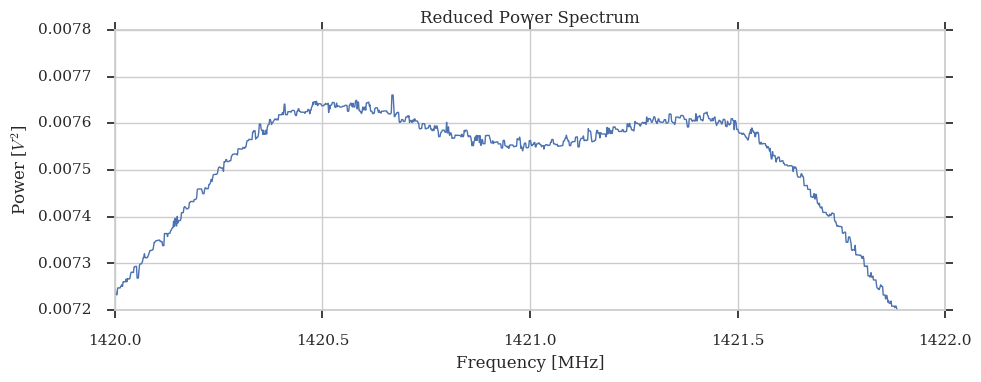

In [254]:
fig = plt.figure(figsize = (10, 4))
plt.plot(freq[0], spec[0], linewidth=1)
plt.xlim(1420,1422)
plt.ylim(0.0072,0.00780001)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [$V^2$]')
plt.title('Reduced Power Spectrum')
plt.tight_layout()

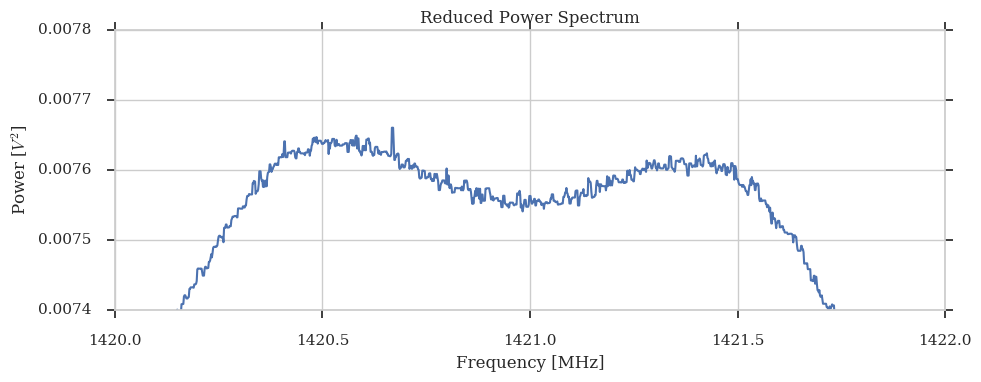

In [255]:
fig = plt.figure(figsize = (10, 4))
plt.plot(freq[0], spec[0])
plt.xlim(1420,1422)
plt.ylim(0.0074,0.0078001)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [$V^2$]')
plt.title('Reduced Power Spectrum')
plt.tight_layout()

C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


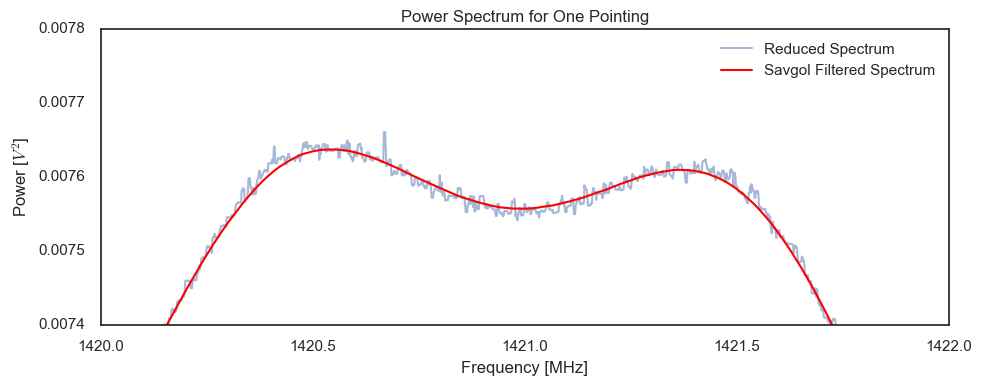

In [490]:
x = freq[0]
y = spec[0]

model = savgol_filter(y, 499, 3)

fig = plt.figure(figsize = (10, 4))

plt.plot(x, y, alpha=0.5, label='Reduced Spectrum')
plt.plot(x, model, color='red', label='Savgol Filtered Spectrum')
plt.xlim(1420,1422)
plt.ylim(0.0074,0.0078001)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [$V^2$]')
plt.title('Power Spectrum for One Pointing')
plt.legend()

plt.tight_layout()

In [343]:
# Centers data and gets rid of the baseline as done above

def center_spec(data):
    new_spec = []
    fit_S = []
    for i in range(len(data)):
        fit = savgol_filter(data[i], 499, 3)
        spec = data[i]-fit
        fit_S.append(fit)
        
        for l in range(len(spec)):
            
            if l <=200 or l >= 8000:
                spec[l] = np.nan
                
            #if freq[i][l] <= 1424:
             #   spec[l] = np.nan
            #if freq[i][l] >= 1424.85:
             #   spec[l] = np.nan
                
        new_spec.append(spec)  
        
        
        
    return np.array(new_spec), np.array(fit_S)  

In [344]:
spec_data, Fit_data = center_spec(spec)
print(len(spec))

C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


500


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


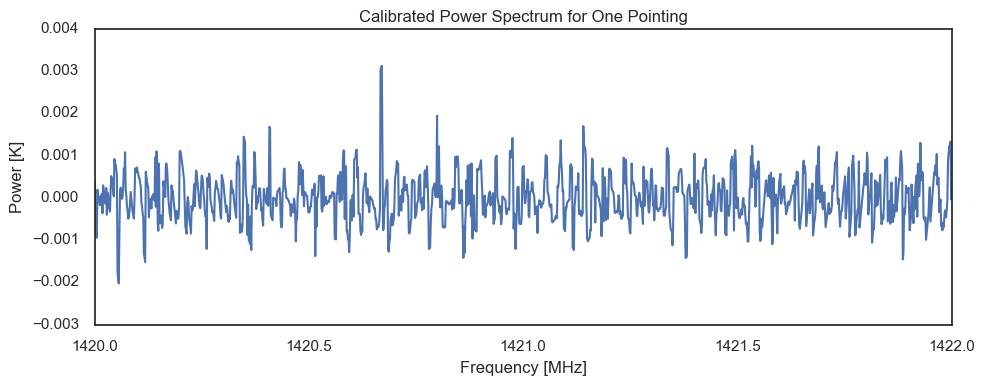

In [317]:
fig = plt.figure(figsize = (10, 4))

plt.plot(freq[0], 86.86991922002115*spec_data[0])
plt.xlim(1420,1422)
#plt.ylim(0.0074,0.0078001)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [K]')
plt.title('Calibrated Power Spectrum for One Pointing')
plt.legend()

plt.tight_layout()

In [13]:
ind = []
freq_peak = []
for i in range(len(spec_data)):
    index = np.nanargmax(spec_data[i])
    ind.append(index)
    freq_peak.append(freq[0][index])
freq_arr = np.array(freq_peak)  

In [14]:
print(len(freq_peak))

500


In [214]:
for i in range(len(freq_peak)):
    if freq_peak[i] >1424:
        freq_peak[i] -= 4
    if freq_peak[i] < 1419:
        freq_peak[i] = 0

In [215]:
def doppler(freq, RA_DEC, JD):
    
    dopp = []
    #spec_val = []
    #plt.figure(figsize = (12,8))    
        
      
    #plt.figure(figsize = (12,8))
    for i in range(len(RA_DEC)): 
        
        nu = 1420.405751786e6 #Hz
        if freq[i] != 0:
            delta_nu = freq[i]*1e6 - nu

            c = 3 * (10**8)
            v = -(delta_nu / nu) * c

            RA = RA_DEC[i][0]
            DEC = RA_DEC[i][1]
            Jd = JD[i]
            doppler_v = get_projected_velocity(RA, DEC, Jd)
            dop_vel = (v - doppler_v)/1000 #converts to km

            dopp.append(dop_vel)
        else:
            dopp.append(0)

    return np.array(dopp)

In [216]:
dop_vel = doppler(freq_peak, RA_DEC, JD)

In [217]:
print(len(np.asarray(dop_vel)))

500


In [218]:
print((dop_vel))

[array([-74.59485644]) array([-75.18797701]) array([-76.92116556])
 array([-77.31364923]) array([-78.83594009]) array([-79.00824805])
 array([-80.30216151]) array([-80.23906669]) array([-62.93251971])
 array([-66.33640922]) array([-66.83000017]) array([-69.98196647])
 array([-63.10583519]) array([-63.53444684]) array([-59.34467285])
 array([-80.8156971]) array([-65.75338524]) array([-55.62109491])
 array([-80.74340081]) array([-79.64996298]) array([-57.91274298])
 array([-78.96645556]) array([-77.52624467]) array([-76.59661033])
 array([-76.18210635]) array([-75.05009711]) array([-73.20612007])
 array([-72.51272147]) array([-71.1197705]) array([-71.80471943])
 array([-72.49869616]) array([-73.7270896]) 0 array([-177.39787642])
 array([-193.19138699]) array([-253.12697247]) array([-56.33791786])
 array([-58.18883007]) array([-57.75788494]) array([-54.42378735])
 array([-55.30149647]) array([-56.98616144]) array([-57.31114533])
 array([-80.82405171]) array([-79.64984446]) array([-80.4482

In [219]:
for i in range(len(dop_vel)):
    print(dop_vel[i], freq_peak[i], coord[i])

[-74.59485644] 1420.6702478329873 [ 60. -80.]
[-75.18797701] 1420.6673177878158 [ 60. -76.]
[-76.92116556] 1420.6702478329873 [ 60. -72.]
[-77.31364923] 1420.6673177878158 [ 60. -68.]
[-78.83594009] 1420.6702478329873 [ 60. -64.]
[-79.00824805] 1420.6673177878158 [ 60. -60.]
[-80.30216151] 1420.6702478329873 [ 60. -56.]
[-80.23906669] 1420.6673177878158 [ 60. -52.]
[-62.93251971] 1420.5833231595655 [ 60. -48.]
[-66.33640922] 1420.597973385423 [ 60. -44.]
[-66.83000017] 1420.5994384080088 [ 60. -40.]
[-69.98196647] 1420.6140886338665 [ 60. -36.]
[-63.10583519] 1420.5818581369797 [ 60. -32.]
[-63.53444684] 1420.586253204737 [ 62. -90.]
[-59.34467285] 1420.5657428885363 [ 62. -86.]
[-80.8156971] 1420.6673177878158 [ 62. -82.]
[-65.75338524] 1420.5965083628373 [ 62. -78.]
[-55.62109491] 1420.5496276400927 [ 62. -74.]
[-80.74340081] 1420.6702478329873 [ 62. -70.]
[-79.64996298] 1420.6673177878158 [ 62. -66.]
[-57.91274298] 1420.567207911122 [ 62. -62.]
[-78.96645556] 1420.6702478329873 [ 62

In [220]:
np.max(dop_vel)

array([255.66085157])

In [221]:
np.min(dop_vel)

array([-527.93972164])

In [128]:
l = np.linspace(60, 110, 26)
b = np.linspace(-90, -30, 31)

ll, bb = np.meshgrid(l,b)

lb_val = []
indexes = []

for i in range(len(ll[:,0])):
    for j in range(len(bb[0,:])):
        
        #HOLDING THE ROW INDEX
        row = i
        #HOLDS THE COLUMN INDEX
        column = j
        
        #HOLDS THE INDEX IN A LIST
        index = [i,j]
        
        #APPENDING THE VALUE FOR LL AND BB INTO THE [L,B] GALACTIC COORDINATES
        lb_val.append([ll[i,j], bb[i,j]])
        indexes.append(index)

In [136]:
print(len(indexes))

806


In [166]:
#MAKING A MATRIX
matrix = np.zeros((31,26,3), dtype = int)

#r_img = img[:,:,0]
#g_img = img[:,:,1]
#b_img = img[:,:,2]

N = 0


for i in range(499):
    
    l = float(coord[i][0])
    b = float(coord[i][1])

    #col = np.linspace(0, 256, 257)
    #values = np.linspace(-501.82434399395436, -306.08842281913303, 257)

        #psueodo data im trying

        #for loop that ranges through the list of galactic values 
    for m in range(len(lb_val)):

            #if statement that checks to see if the galactic coordinates match up and appends
            #them to the proper index in the matrix
            
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        #CHECKING TO SEE IF COORDINATES MATCH THE L AND B VALUE FOR THE MATRIX
        if l == lb_val[m][0] and b == lb_val[m][1]:
            #GETS THE INDEXES
            row_index = indexes[m][0]
            column_index = indexes[m][1]

            #GETTING THE CORRESPONDING VELOCITY
            dop = dop_vel[i]
            
            #IF NEGATIVE GO TO THIS CODE BLOCK
            if dop < 0:
                #MAKING A LIST OF INTEGERS FOR COLOR MAPPING
                val = list(reversed(np.arange(0, 256, 1)))
                #THE VELOCITY MAP
                mapp = np.linspace(np.amin(dop_vel), 0, 256)
                
                #GETTING INDEX TO WHERE THE MAPP AND VALUE ARE THE CLOSEST
                indx = find_nearest(mapp, dop)
                
                #GETTING THE CORRESPONDING VALUE FOR THE COLOR
                color = val[indx]
                
                #APPENDING THAT TO THE RED PART OF THE MATRIX
                matrix[row_index, column_index, 0] = int(color)
            
            #IF POSITIVE VELOCITY
            if dop > 0:
                
                #SAME DEAL AS BEFORE BUT NOW WITH POSITIVE MAPPING
                val = np.arange(0, 256, 1)
                mapp = np.linspace(0, np.amax(dop_vel), 256)
                
                indx = find_nearest(mapp, dop)
                
                color = val[indx]
                matrix[row_index, column_index, 2] = int(color)
        
                
print(matrix) 

[[[  0   0   0]
  [ 31   0   0]
  [  0   0   0]
  ...
  [ 67   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [ 35   0   0]
  ...
  [ 67   0   0]
  [112   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [ 29   0   0]
  [  0   0   0]
  ...
  [ 67   0   0]
  [ 19   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [ 35   0   0]
  [  0   0   0]
  ...
  [ 17   0   0]
  [ 24   0   0]
  [  0   0   0]]

 [[ 30   0   0]
  [  0   0   0]
  [ 39   0   0]
  ...
  [113   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [ 34   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


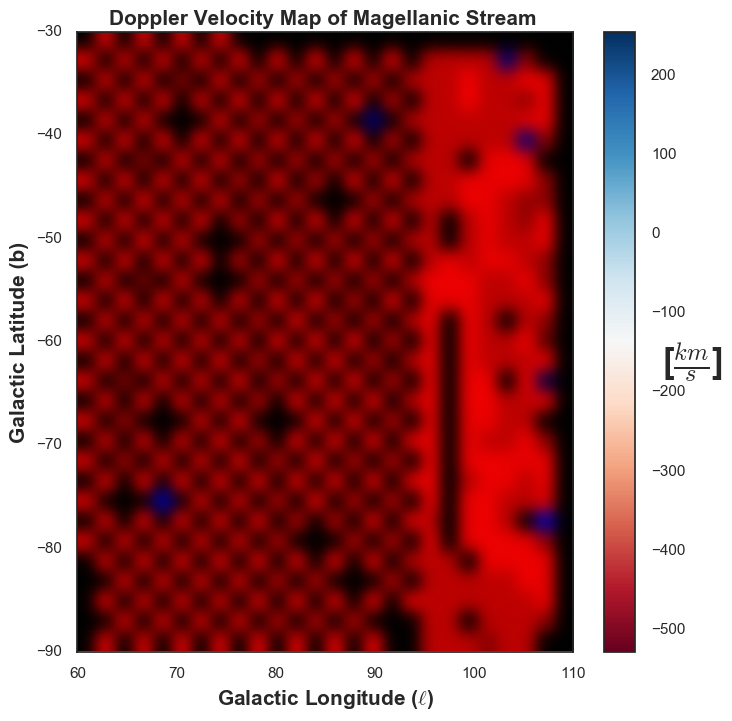

In [322]:
plt.figure(figsize = (8,8))
plt.title('Doppler Velocity Map of Magellanic Stream ', fontsize = 15, weight = 'semibold')
plt.imshow(matrix, cmap = 'RdBu', interpolation= 'gaussian', aspect = 'auto', origin = 'lower', extent=[60,110,-90,-30], vmin=np.amin(dop_vel), vmax=np.amax(dop_vel))

plt.xlabel(r'Galactic Longitude ($\ell$)', fontsize = 15, weight = 'semibold')
plt.ylabel('Galactic Latitude (b)', fontsize = 15, weight = 'semibold')
cbar = plt.colorbar()
cbar.set_label(r'[$\frac{km}{s}$]', rotation=0, fontsize = 25, fontweight = 'semibold')

In [523]:
matrix1 = np.zeros((31,26))


N = 0
for i in range(len(coord)):
    
    l = float(coord[i][0])
    b = float(coord[i][1])

    #col = np.linspace(0, 256, 257)
    #values = np.linspace(-501.82434399395436, -306.08842281913303, 257)

        #psueodo data im trying

        #for loop that ranges through the list of galactic values 
    for m in range(len(lb_val)):

            #if statement that checks to see if the galactic coordinates match up and appends
            #them to the proper index in the matrix
            
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        if l == lb_val[m][0] and b == lb_val[m][1]:
            #print(N)
            #N+=1
                #print(l, b)
            #loop.append([l,b])
                #print(N)
                #N+=1
                #gets the matrix indices from indexes
            row_index = indexes[m][0]
            column_index = indexes[m][1]

                #appending a value to the matrix
            dop = dop_vel[i]
            
            
                
            matrix1[row_index, column_index] = dop
        

C:\Users\matth\AppData\Roaming\Python\Python35\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\matth\AppData\Roaming\Python\Python35\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


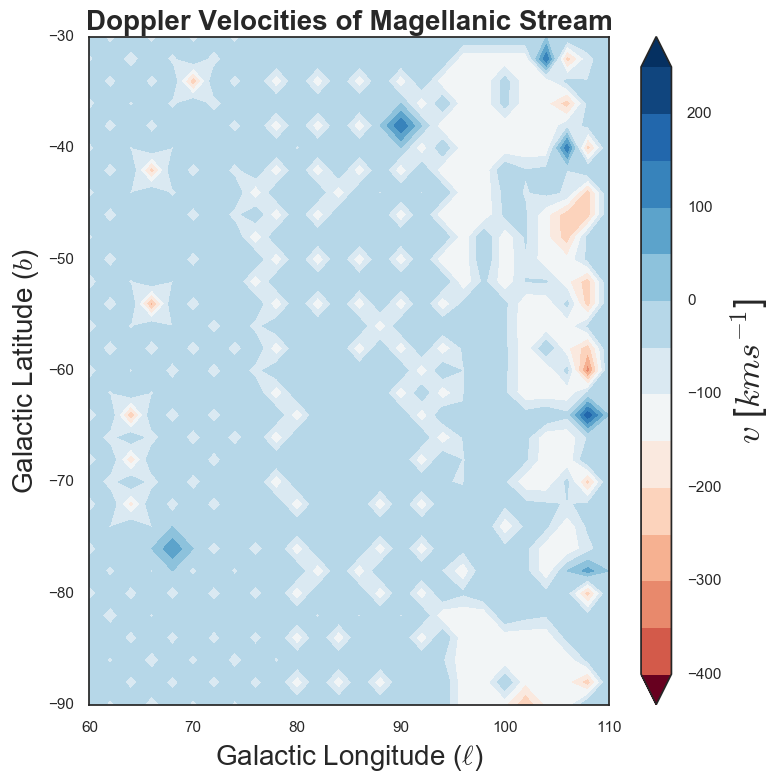

In [550]:
plt.style.use('seaborn-white')
plt.figure(figsize = (8,8))
plt.title('Doppler Velocities of Magellanic Stream', fontsize = 20, weight = 'bold')
plt.contourf(matrix1, interpolation='linear',levels = np.arange(-400, 300, 50), cmap = 'RdBu', extend = 'both', origin = None, extent=[60,110,-90,-30], vmin=np.amin(dop_vel), vmax=np.amax(dop_vel))
plt.xlabel(r'Galactic Longitude ($\ell$)', fontsize = 20)
plt.ylabel('Galactic Latitude ($b$)', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label(r'$v$ [$kms^{-1}$]', rotation=90, fontsize = 25)
plt.tight_layout()


In [309]:
dop_vels = []
for i in range(len(dop_vel)):
    vel = float(dop_vel[i])
    dop_vels.append(vel)
    
mean , std = norm.fit(dop_vels)
print('mean =',mean, 'std =',std, 'median =',np.median(dop_vels))

mean = -84.09599449014564 std = 65.34680339139325 median = -71.33231140941913


In [556]:
Hvel = 1420.40575 * 0.21 / 1000

M=0
for i in dop_vels:
    if i == 0:
        M+=1
    else:
        M+0
print(M)

35


In [552]:
Ns = []
for i in range(len(dop_vels)):
    if dop_vels[i] > 0:
        N = 1.8e18*0.003*dop_vels[i]*1e5
        Ns.append(int(N))
    if dop_vels[i] < 0:
        N = 1.8e18*0.003*np.abs(dop_vels[i])*1e5 
        Ns.append(int(N))
    if dop_vels[i] == 0:
        N = 1.8e18*0.003*Hvel*1e5
        Ns.append(int(N))

print(len(Ns), np.max(Ns), np.min(Ns))

500 285087449686637407109120 161074012049999986688


In [425]:
matrix2 = np.zeros((31,26))


N = 0
for i in range(len(coord)):
    
    l = float(coord[i][0])
    b = float(coord[i][1])

    #col = np.linspace(0, 256, 257)
    #values = np.linspace(-501.82434399395436, -306.08842281913303, 257)

        #psueodo data im trying

        #for loop that ranges through the list of galactic values 
    for m in range(len(lb_val)):

            #if statement that checks to see if the galactic coordinates match up and appends
            #them to the proper index in the matrix
            
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        if l == lb_val[m][0] and b == lb_val[m][1]:
            #print(N)
            #N+=1
                #print(l, b)
            #loop.append([l,b])
                #print(N)
                #N+=1
                #gets the matrix indices from indexes
            row_index = indexes[m][0]
            column_index = indexes[m][1]

                #appending a value to the matrix
            N = Ns[i]
            
            
                
            matrix2[row_index, column_index] = dop
   

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\matth\AppData\Roaming\Python\Python35\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\matth\AppData\Roaming\Python\Python35\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return sel

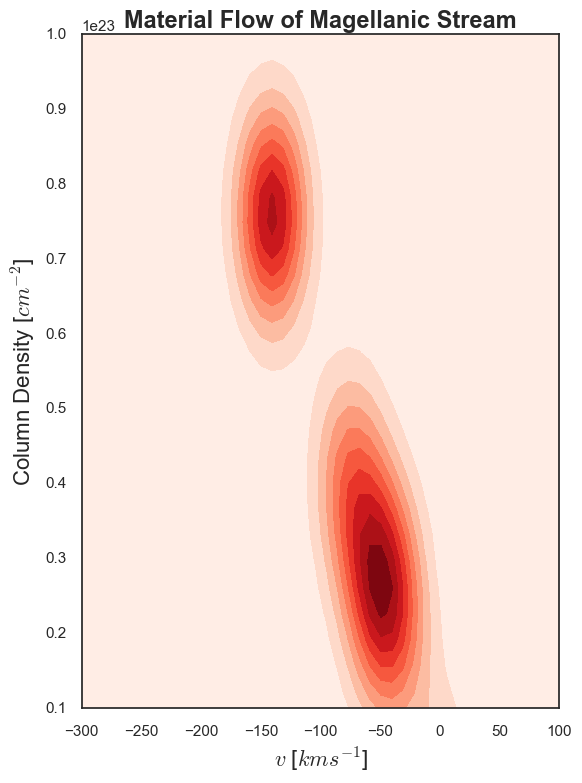

In [529]:
plt.style.use('seaborn-white')
plt.figure(figsize = (6,8))

sbn.kdeplot(dop_vels, Ns, cmap='Reds', shade=True, interpolation='linear')
plt.title('Material Flow of Magellanic Stream', fontsize = 17, weight = 'bold')
plt.ylim(1e22,1e23)
plt.xlim(-300, 100)
plt.xlabel(r'$v$ [$kms^{-1}$]', rotation=0, fontsize = 16)
plt.ylabel(r'Column Density [$cm^{-2}$]', rotation=90, fontsize = 16)

plt.tight_layout()

plt.savefig('materials', dpi = 1200,  transparent = True)

In [500]:
print(coord[0])

[ 60. -80.]


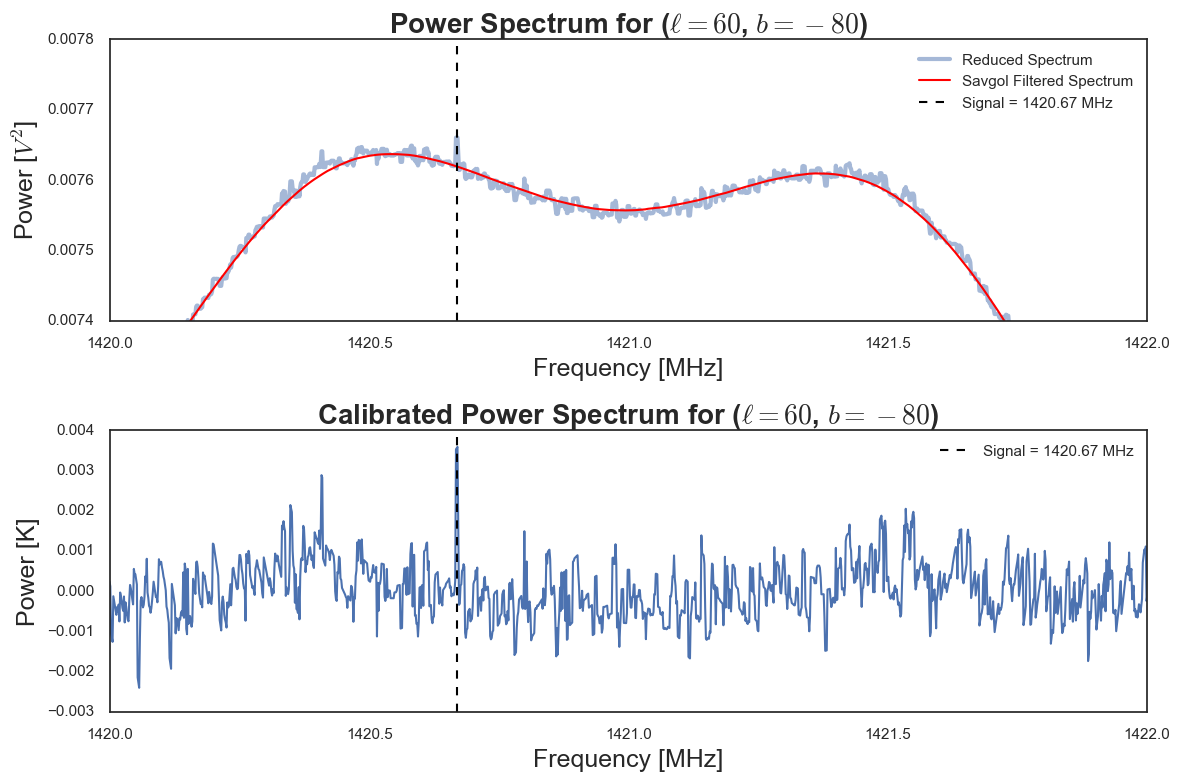

In [530]:
plt.style.use('seaborn-white')

fig, axes = plt.subplots(nrows=2,ncols=1, figsize = (12,8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(x, y, alpha=0.5, label='Reduced Spectrum', linewidth=3)
ax1.plot(x, model, color='red', label='Savgol Filtered Spectrum')
ax1.set_xlim(1420,1422)
ax1.set_ylim(0.0074,0.0078001)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Frequency [MHz]', fontsize=18)
ax1.set_ylabel('Power [$V^2$]', fontsize=18)
ax1.axvline(1420.67, linestyle='--', label='Signal = 1420.67 MHz', color='black')
ax1.set_title('Power Spectrum for ($\ell=60$, $b=-80$)', fontweight='bold', fontsize=20)
ax1.legend()

ax2 = plt.subplot(2, 1, 2)
ax2.plot(freq[0], 86.86991922002115*spec_data[0])
ax2.set_xlim(1420,1422)
ax2.set_ylim(-.003,.004)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Frequency [MHz]', fontsize=18)
ax2.set_ylabel('Power [K]', fontsize=18)
ax2.axvline(1420.67, linestyle='--', label='Signal = 1420.67 MHz', color='black')
ax2.set_title('Calibrated Power Spectrum for ($\ell=60$, $b=-80$)', fontweight='bold', fontsize=20)
ax2.legend()

fig.tight_layout()

plt.savefig('spectra', dpi = 1200,  transparent = True)

In [538]:
def error(data):
    
    errors = []
    
    for i in range(len(data) - 1):
        diff = data[i+1] - data[i]
        errors.append(diff)
        
    last = np.mean(errors)
    errors.append(last)
    
    return errors

In [539]:
vel_err = error(dop_vels)

Std: 83.31525933372147


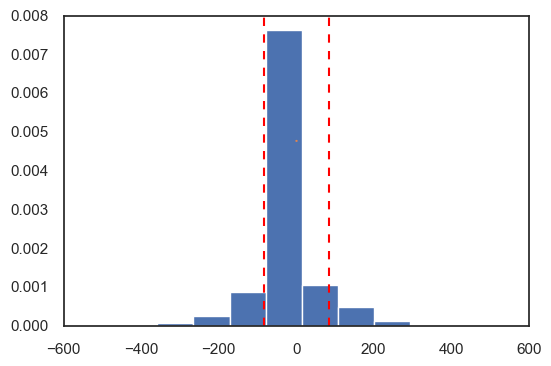

In [543]:
mean , std = norm.fit(vel_err)


xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.hist(vel_err, bins=10, normed=True)
plt.plot(x, y)
plt.axvline(-std, linestyle='--', color='red')
plt.axvline(std, linestyle='--', color='red')
print('Std:', std)

In [544]:
error = 83.315 / 1420.67 * 100
print(error,'%')

5.864486474691518 %


In [547]:
print(np.median(freq_peak), np.mean(freq_peak))

1420.6673177878158 1321.2915087290928
